In [ ]:
!pip install bertopic
!pip install -U numpy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from bertopic import BERTopic
import pandas as pd
from collections import defaultdict
import random
from itertools import chain
import pickle
from tqdm import tqdm
from collections import Counter
from operator import itemgetter
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
# CONSTANTS

random.seed(42)

# Quotebank years list
YEARS = range(2015, 2021)

# Path to filtered quotebank dataset (one party per speaker)
QUOTEBANK_ONE_PARTY = {year: f"/content/drive/MyDrive/Quotebank_sets/ADA_data/quotebank_one_party-{year}.csv" for year in YEARS}

# Maximum number of quotes per party in each of the 6 years
MAX_QUOTES_PER_PARTY = [170, 225, 155, 145, 145, 530]

# Path to fitted models by year
FITTED_BERT_PER_YEAR_PATH = {year: f'/content/drive/MyDrive/Quotebank_sets/ADA_models/{year}_topic_model' for year in YEARS}

# Path to quotes per year used for fitting
FITTED_QUOTES_PER_YEAR_PATH = {year: f'/content/drive/MyDrive/Quotebank_sets/ADA_data/{year}_fit_data.pkl' for year in YEARS}

# Path to topics for quotes, per year
QUOTES_TOPICS_PER_YEAR_PATH = {year: f'/content/drive/MyDrive/Quotebank_sets/ADA_models/{year}_all_topics.pkl' for year in YEARS}

# Path to final quotes with named topics dataframe
FINAL_NAMED_TOPICS_QUOTES_PER_YEAR_PATH = {year: f'/content/drive/MyDrive/Quotebank_sets/ADA_data/final-quotes-named-topics-{year}.csv' for year in YEARS}



In [ ]:
# HELPERS

def choose_quotes(row, max_quotes):
    """
    If number of quotes per party below max_quotes, select all,
    otherwise select randomly max_quotes quotes for a party.
    """
    if not row['select_all']:
        # Randomly sample max_quotes quotes
        row['quotes_list'] = random.sample(row['quotes_list'], max_quotes)
        row['number'] = max_quotes
    return row


def get_quotes_for_year_fit():
    """
    Get yearly political parties quotes required for fitting BERTopic.
    """
    # Dictionary with quotes per year (around 100K quotes for each year)
    quotes_by_year = defaultdict(list)

    for i, quote_year in tqdm(enumerate(YEARS)):
        df = pd.read_csv(QUOTEBANK_ONE_PARTY[quote_year], index_col=[0])
        # Group by party
        groupby_party = df.groupby('party_one')['quotation'].agg(quotes_list=list, number=len)
        # Create boolean column with True values if number of quotes for party is above threshold
        groupby_party['select_all'] = groupby_party['number'] <= MAX_QUOTES_PER_PARTY[i]
        # Create a the list of quotes for a year
        quotes = groupby_party.apply(lambda x: choose_quotes(x, MAX_QUOTES_PER_PARTY[i]), axis=1)['quotes_list'].values
        quotes = list(chain.from_iterable(quotes))
        quotes_by_year[quote_year] = quotes
        # Also save data used for fiiting because we need it later
        with open(FITTED_QUOTES_PER_YEAR_PATH[quote_year], 'wb') as f:
            pickle.dump(quotes, f)

    return quotes_by_year


def fit_years(start_year, end_year):
    """
    Function for fiiting BERTopic on quotes from each year.
    """
    yearly_quotes = get_quotes_for_year_fit()
    for i, quote_year in enumerate(range(start_year, end_year)):
        # Instantiate BERTopic
        topic_model = BERTopic(verbose=True)
        # Fit a model on topics of each year
        topics = topic_model.fit(yearly_quotes[quote_year])
        print(f'Saving model for {quote_year}')
        # Save model
        topic_model.save(FITTED_BERT_PER_YEAR_PATH[quote_year])


def transform_years(models_by_year, quotes_by_year):
    """
    Function for predicting topics on quotes from each year.
    """
    for year in models_by_year.keys():
        model_topics_all, model_probs_all = models_by_year[year].transform(quotes_by_year[year])
        with open(QUOTES_TOPICS_PER_YEAR_PATH[year], 'wb') as f:
            pickle.dump([model_topics_all, model_probs_all], f)


def get_all_quotes_for_year(year, return_quote_ids=False):
    """
    Get all quotes from a year.
    """
    df = pd.read_csv(QUOTEBANK_ONE_PARTY[year])
    res = df[['quoteID', 'quotation']]
    if return_quote_ids:
        return res['quotation'].tolist(), res['quoteID'].tolist()
    else:
        return res['quotation'].tolist(), None

In [ ]:
def per_years_analysis(fit_all_first=False, transform_all_first=False, start_year=2015, end_year=2021):
    # Fit models first, if necessary
    if fit_first:
        fit_years(start_year, end_year)

    # Instantiate a BERTopic model for each year
    models = {}
    quotes_all = {}
    for year in range(start_year, end_year):
        # Store models for each year
        models[year] = BERTopic(verbose=True).load(FITTED_BERT_PER_YEAR_PATH[year])
        # Get all quotes for each year
        year_quotes, year_quote_id = get_all_quotes_for_year(year, return_quote_ids=False)
        quotes_all[year] = year_quotes

    # Predict topics on each year quotes, if necessary
    if transform_first:
        transform_years(models, quotes_all)

    for year in range(start_year, end_year):
        # Get quotes topics
        with open(QUOTES_TOPICS_PER_YEAR_PATH[year], 'rb') as topic_file:
            model_topics_all, model_probs_all = pickle.load(topic_file)

        # Remove quotes which are not clustered into a topic
        quotes_all = [x for i, x in enumerate(quotes_all[year]) if model_topics_all[i] != -1]
        model_probs_all = [x for i, x in enumerate(model_probs_all) if model_topics_all[i] != -1]
        model_topics_all = [x for x in model_topics_all if x != -1]

        # Automatic reduction


        # Manual reduction


In [ ]:
models = {}
quotes_all = {}
year = 2015
models[year] = BERTopic(verbose=True).load(FITTED_BERT_PER_YEAR_PATH[year])
year_quotes, year_quote_id = get_all_quotes_for_year(year, return_quote_ids=True)
quotes_all[year] = year_quotes
# transform_years(models, quotes_all)

In [ ]:
with open(QUOTES_TOPICS_PER_YEAR_PATH[year], 'rb') as topic_file:
            model_topics_all, model_probs_all = pickle.load(topic_file)

In [ ]:
# Number of quotes right after transform
print(len(quotes_all[year]))
print(len(model_topics_all))

1644663
1644663


In [ ]:
# Number of quotes after removing non-clustered ones
only_clustered = [x for i, x in enumerate(quotes_all[year]) if model_topics_all[i] != -1]
only_clustered_id = [year_quote_id[i] for i, x in enumerate(quotes_all[year]) if model_topics_all[i] != -1]
print(len(only_clustered))
# model_probs_all = [x for i, x in enumerate(model_probs_all) if model_topics_all[i] != -1]
model_topics_all = [x for x in model_topics_all if x != -1]
print(len(model_topics_all))

669642
669642


In [ ]:
new_topics, new_probs = models[year].reduce_topics(only_clustered, model_topics_all, nr_topics=80)

2021-12-11 23:25:56,588 - BERTopic - Reduced number of topics from 846 to 81


In [ ]:
quote_to_topic_df = pd.DataFrame({'quote_id': only_clustered_id, 'quote': only_clustered, 'topic': new_topics}). set_index('quote_id')
quote_to_topic_df

,quote,topic
quote_id,,
2015-08-31-000271,... a great day for veterans here in Littleton...,68
2015-05-10-027625,It's been my experience that the faith communi...,46
2015-09-01-113454,we need to bring the parents in so they can se...,0
2015-05-26-009760,Every child has the right to be recognized and...,30
2015-08-31-096491,We have a duty to provide our veterans with th...,68
...,...,...
2015-07-30-069360,made it clear that these two activities were l...,12
2015-10-17-031341,"is now a free man, who can talk whenever he li...",3
2015-07-24-018672,Education. 22 percent of all of the population...,0


In [ ]:
quote_to_topic_df[quote_to_topic_df['topic'] == 6].iloc[73].quote

'the business of installing LED lights in the country at a cost of Rs.25,000 crore-Rs.30,000 crore'

In [ ]:
models[year].get_topic(6)

[('community', 0.013793504966549483),
 ('leadership', 0.013444542808109979),
 ('christmas', 0.009518512485078158),
 ('leader', 0.009188724130674274),
 ('najib', 0.009125377175540747),
 ('festival', 0.007024849855268546),
 ('celebrate', 0.005898779701731915),
 ('volunteers', 0.00588377240983138),
 ('memorial', 0.005383636907413122),
 ('greetings', 0.004656752164786864)]

In [ ]:
s = [
'0 - education',
'1 - transportation',
'2 - women',
'3 - communication/public relations',
'4 - crimes',
'5 - southern asia',
'6 - community/leadership',
'7 - iran/russia',
'8 - sports',
'9 - refugees/immigrants',
'10 - india',
'11 - media',
'12 - european union',
'13 - diseases/vaccines',
'14 - gender equality',
'15 - ministers',
'16 - war and violence (peace)',
'17 - negotiations',
'18 - healthcare',
'19 - voting/elections',
'20 - canada',
'21 - planning/proposals',
'22 - democracy',
'23 - economy',
'24 - israel/palestine',
'25 - africa',
'26 - filipines',
'27 - malaysia/singapore',
'28 - illegal substances',
'29 - employment/wages',
'30 - kids/family',
'31 - uk',
'32 - middle-east',
'33 - energy',
'34 - justice',
'35 - tax',
'36 - national organizations/international cooperation',
'37 - parliament',
'38 - politics',
'39 - terrorism',
'40 - australia/oceania',
'41 - government',
'42 - legislation',
'43 - rights/freedom',
'44 - loan/debts',
'45 - food/hunger',
'46 - religion',
'47 - policies/regulations',
'48 - east-asia',
'49 - sea-life/fishing',
'50 - south-america',
'51 - agriculture',
'52 - urban areas/mayors',
'53 - business and innovation',
'54 - pollution',
'55 - syria/isis',
'56 - flooding',
'57 - abortion',
'58 - councils/meetings',
'59 - islam',
'60 - law enforcement',
'61 - france/terrorism',
'62 - climate change',
'63 - apologize/regret',
'64 - senate',
'65 - island countries',
'66 - lgbt',
'67 - problems/solutions',
'68 - veterans',
'69 - parties',
'70 - markets',
'71 - economic sitaution',
'72 - budget/spendings',
'73 - natural disasters',
'74 - housing/homelessness',
'75 - renewable energy',
'76 - guns/shootings',
'77 - aviation',
'78 - protests',
'79 - science/progress',
'80 - unions'
]
d = {}
for ss in s:
    k, v = ss.split(' - ')
    d[int(k)] = v
topic_mapping = pd.DataFrame({'topic_number': d.keys(), 'topic_name':d.values()}).set_index('topic_number')

In [ ]:
df_original = pd.read_csv(QUOTEBANK_ONE_PARTY[year], index_col=[0]).set_index('quoteID')
final_df = df_original.merge(quote_to_topic_df[['topic']], how='inner', left_index=True, right_index=True)
final_df = final_df.merge(topic_mapping, how='inner', left_on='topic', right_index=True)
final_df.to_csv(FINAL_NAMED_TOPICS_QUOTES_PER_YEAR_PATH[year])

In [ ]:
final_df = pd.read_csv(FINAL_NAMED_TOPICS_QUOTES_PER_YEAR_PATH[2015], index_col=[0])
final_df.head()

,quotation,qids,party,party_qcodes,party_one,speaker,topic,topic_name
2015-08-31-000271,... a great day for veterans here in Littleton...,['Q270316'],['Democratic Party'],['Q29552'],Democratic Party,Jeanne Shaheen,68,veterans
2015-08-31-096491,We have a duty to provide our veterans with th...,['Q270316'],['Democratic Party'],['Q29552'],Democratic Party,Jeanne Shaheen,68,veterans
2015-10-15-147498,We owe such a debt to our disabled veterans fo...,['Q270316'],['Democratic Party'],['Q29552'],Democratic Party,Jeanne Shaheen,68,veterans
2015-06-27-041878,"veterans with identical service records, disab...",['Q270316'],['Democratic Party'],['Q29552'],Democratic Party,Jeanne Shaheen,68,veterans
2015-06-08-062458,"Veterans served their country bravely, and yet...",['Q270316'],['Democratic Party'],['Q29552'],Democratic Party,Jeanne Shaheen,68,veterans


In [ ]:
# Remove independent politicians
final_df = final_df[final_df['party_one'] != 'independent politician']
final_df.head()

,quotation,qids,party,party_qcodes,party_one,speaker,topic,topic_name
2015-08-31-000271,... a great day for veterans here in Littleton...,['Q270316'],['Democratic Party'],['Q29552'],Democratic Party,Jeanne Shaheen,68,veterans
2015-08-31-096491,We have a duty to provide our veterans with th...,['Q270316'],['Democratic Party'],['Q29552'],Democratic Party,Jeanne Shaheen,68,veterans
2015-10-15-147498,We owe such a debt to our disabled veterans fo...,['Q270316'],['Democratic Party'],['Q29552'],Democratic Party,Jeanne Shaheen,68,veterans
2015-06-27-041878,"veterans with identical service records, disab...",['Q270316'],['Democratic Party'],['Q29552'],Democratic Party,Jeanne Shaheen,68,veterans
2015-06-08-062458,"Veterans served their country bravely, and yet...",['Q270316'],['Democratic Party'],['Q29552'],Democratic Party,Jeanne Shaheen,68,veterans


In [ ]:
topic_count_per_year = Counter(final_df['topic_name'])
most_common_topics = dict(topic_count_per_year.most_common())
most_common_topics = pd.DataFrame({'subject': most_common_topics.keys(), 'nr_quotes': most_common_topics.values()})
most_common_topics[:20]

,subject,nr_quotes
0,education,29751
1,transportation,19330
2,women,16851
3,communication/public relations,15828
4,crimes,15107
5,southern asia,14671
6,community/leadership,13946
7,iran/russia,13103
8,sports,12763
9,refugees/immigrants,11611


In [ ]:
party_to_topics = final_df.groupby(['party_one', 'topic_name']).count()['quotation']

In [ ]:
party_to_topics['Democratic Party'].sort_values(ascending=False)[:25]

topic_name
education                         10771
women                              6422
transportation                     5849
iran/russia                        4621
communication/public relations     3997
crimes                             3913
gender equality                    3660
community/leadership               3506
urban areas/mayors                 3429
diseases/vaccines                  3361
negotiations                       3180
illegal substances                 3108
economy                            3036
planning/proposals                 2868
sports                             2864
healthcare                         2852
war and violence (peace)           2759
middle-east                        2751
democracy                          2622
kids/family                        2570
legislation                        2557
employment/wages                   2543
media                              2388
guns/shootings                     2294
voting/elections             

In [ ]:
party_to_topics['Republican Party'].sort_values(ascending=False)[:25]

topic_name
education                         8739
women                             5322
communication/public relations    4403
politics                          3873
iran/russia                       3762
voting/elections                  3610
transportation                    3539
legislation                       3331
abortion                          3308
crimes                            3243
refugees/immigrants               3192
healthcare                        3147
tax                               3138
religion                          3070
community/leadership              3045
diseases/vaccines                 3041
sports                            2946
senate                            2811
justice                           2802
planning/proposals                2605
democracy                         2516
negotiations                      2443
illegal substances                2372
media                             2268
war and violence (peace)          2238
Name: quotatio

In [ ]:
most_important_k = 20
less_important_parties = list(dict(Counter(final_df['party_one']).most_common()[most_important_k:]).keys())
party_to_topics_df = pd.DataFrame(party_to_topics).rename(columns={'quotation': 'nr_quotes'})
party_to_topics_df = party_to_topics_df.drop(less_important_parties, level=0)
party_to_topics_df

nr_quotes
party_one                           topic_name                         
African National Congress           abortion                          7
                                    africa                          761
                                    agriculture                      46
                                    apologize/regret                 51
                                    australia/oceania                 9
...                                                                 ...
United Malays National Organisation urban areas/mayors               13
                                    veterans                          4
                                    voting/elections                 51
                                    war and violence (peace)         66
                                    women                            39

[1595 rows x 1 columns]

In [ ]:
quotes_per_party = party_to_topics_df.groupby(level=0).sum()
party_to_topics_df = party_to_topics_df.merge(quotes_per_party, how='inner', right_index=True, left_on='party_one', suffixes=['', '_total'])
party_to_topics_df['party_quotes_percentage'] = (party_to_topics_df['nr_quotes'] / xxx['nr_quotes_total']) * 100
party_to_topics_df

nr_quotes  ...  party_quotes_percentage
party_one                           topic_name                           ...                         
African National Congress           abortion                          7  ...                 0.124555
                                    africa                          761  ...                13.540925
                                    agriculture                      46  ...                 0.818505
                                    apologize/regret                 51  ...                 0.907473
                                    australia/oceania                 9  ...                 0.160142
...                                                                 ...  ...                      ...
United Malays National Organisation urban areas/mayors               13  ...                 0.167009
                                    veterans                          4  ...                 0.051387
                                    voting/elections                 51  ...                 0.655190
                                    war and violence (peace)         66  ...                 0.847893
                                    women                            39  ...                 0.501028

[1595 rows x 3 columns]

In [ ]:
# party_to_topics_tmp = party_to_topics_df.sort_values(['party_one', 'nr_quotes'], ascending=[True, False]).groupby(level=0).head(30)
party_to_topics_tmp = party_to_topics_df.sort_values(['party_one', 'party_quotes_percentage'], ascending=[True, False]).groupby(level=0).head(40)
party_to_topics_tmp
# party_to_topics_tmp = party_to_topics_df

nr_quotes  ...  party_quotes_percentage
party_one                           topic_name                   ...                         
African National Congress           africa                  761  ...                13.540925
                                    education               441  ...                 7.846975
                                    gender equality         276  ...                 4.911032
                                    government              246  ...                 4.377224
                                    crimes                  228  ...                 4.056940
...                                                         ...  ...                      ...
United Malays National Organisation apologize/regret         62  ...                 0.796506
                                    justice                  62  ...                 0.796506
                                    southern asia            58  ...                 0.745118
                                    government               54  ...                 0.693731
                                    east-asia                52  ...                 0.668037

[800 rows x 3 columns]

In [ ]:
# nodes_size = party_to_topics_tmp.sum(level=[0]).sort_index(ascending=True)
nodes_size = quotes_per_party

In [ ]:
# graph_df = pd.DataFrame(party_to_topics_tmp).reset_index().rename(columns={'nr_quotes': "weight", 'party_one': 'party'})
graph_df = pd.DataFrame(party_to_topics_tmp).reset_index().rename(columns={'party_quotes_percentage': "weight", 'party_one': 'party'})
G = nx.convert_matrix.from_pandas_edgelist(graph_df, 'party', 'topic_name', ['weight'])
labels = {i:i for i in dict(G.nodes).keys()}
print(nx.info(G))

Graph with 101 nodes and 800 edges


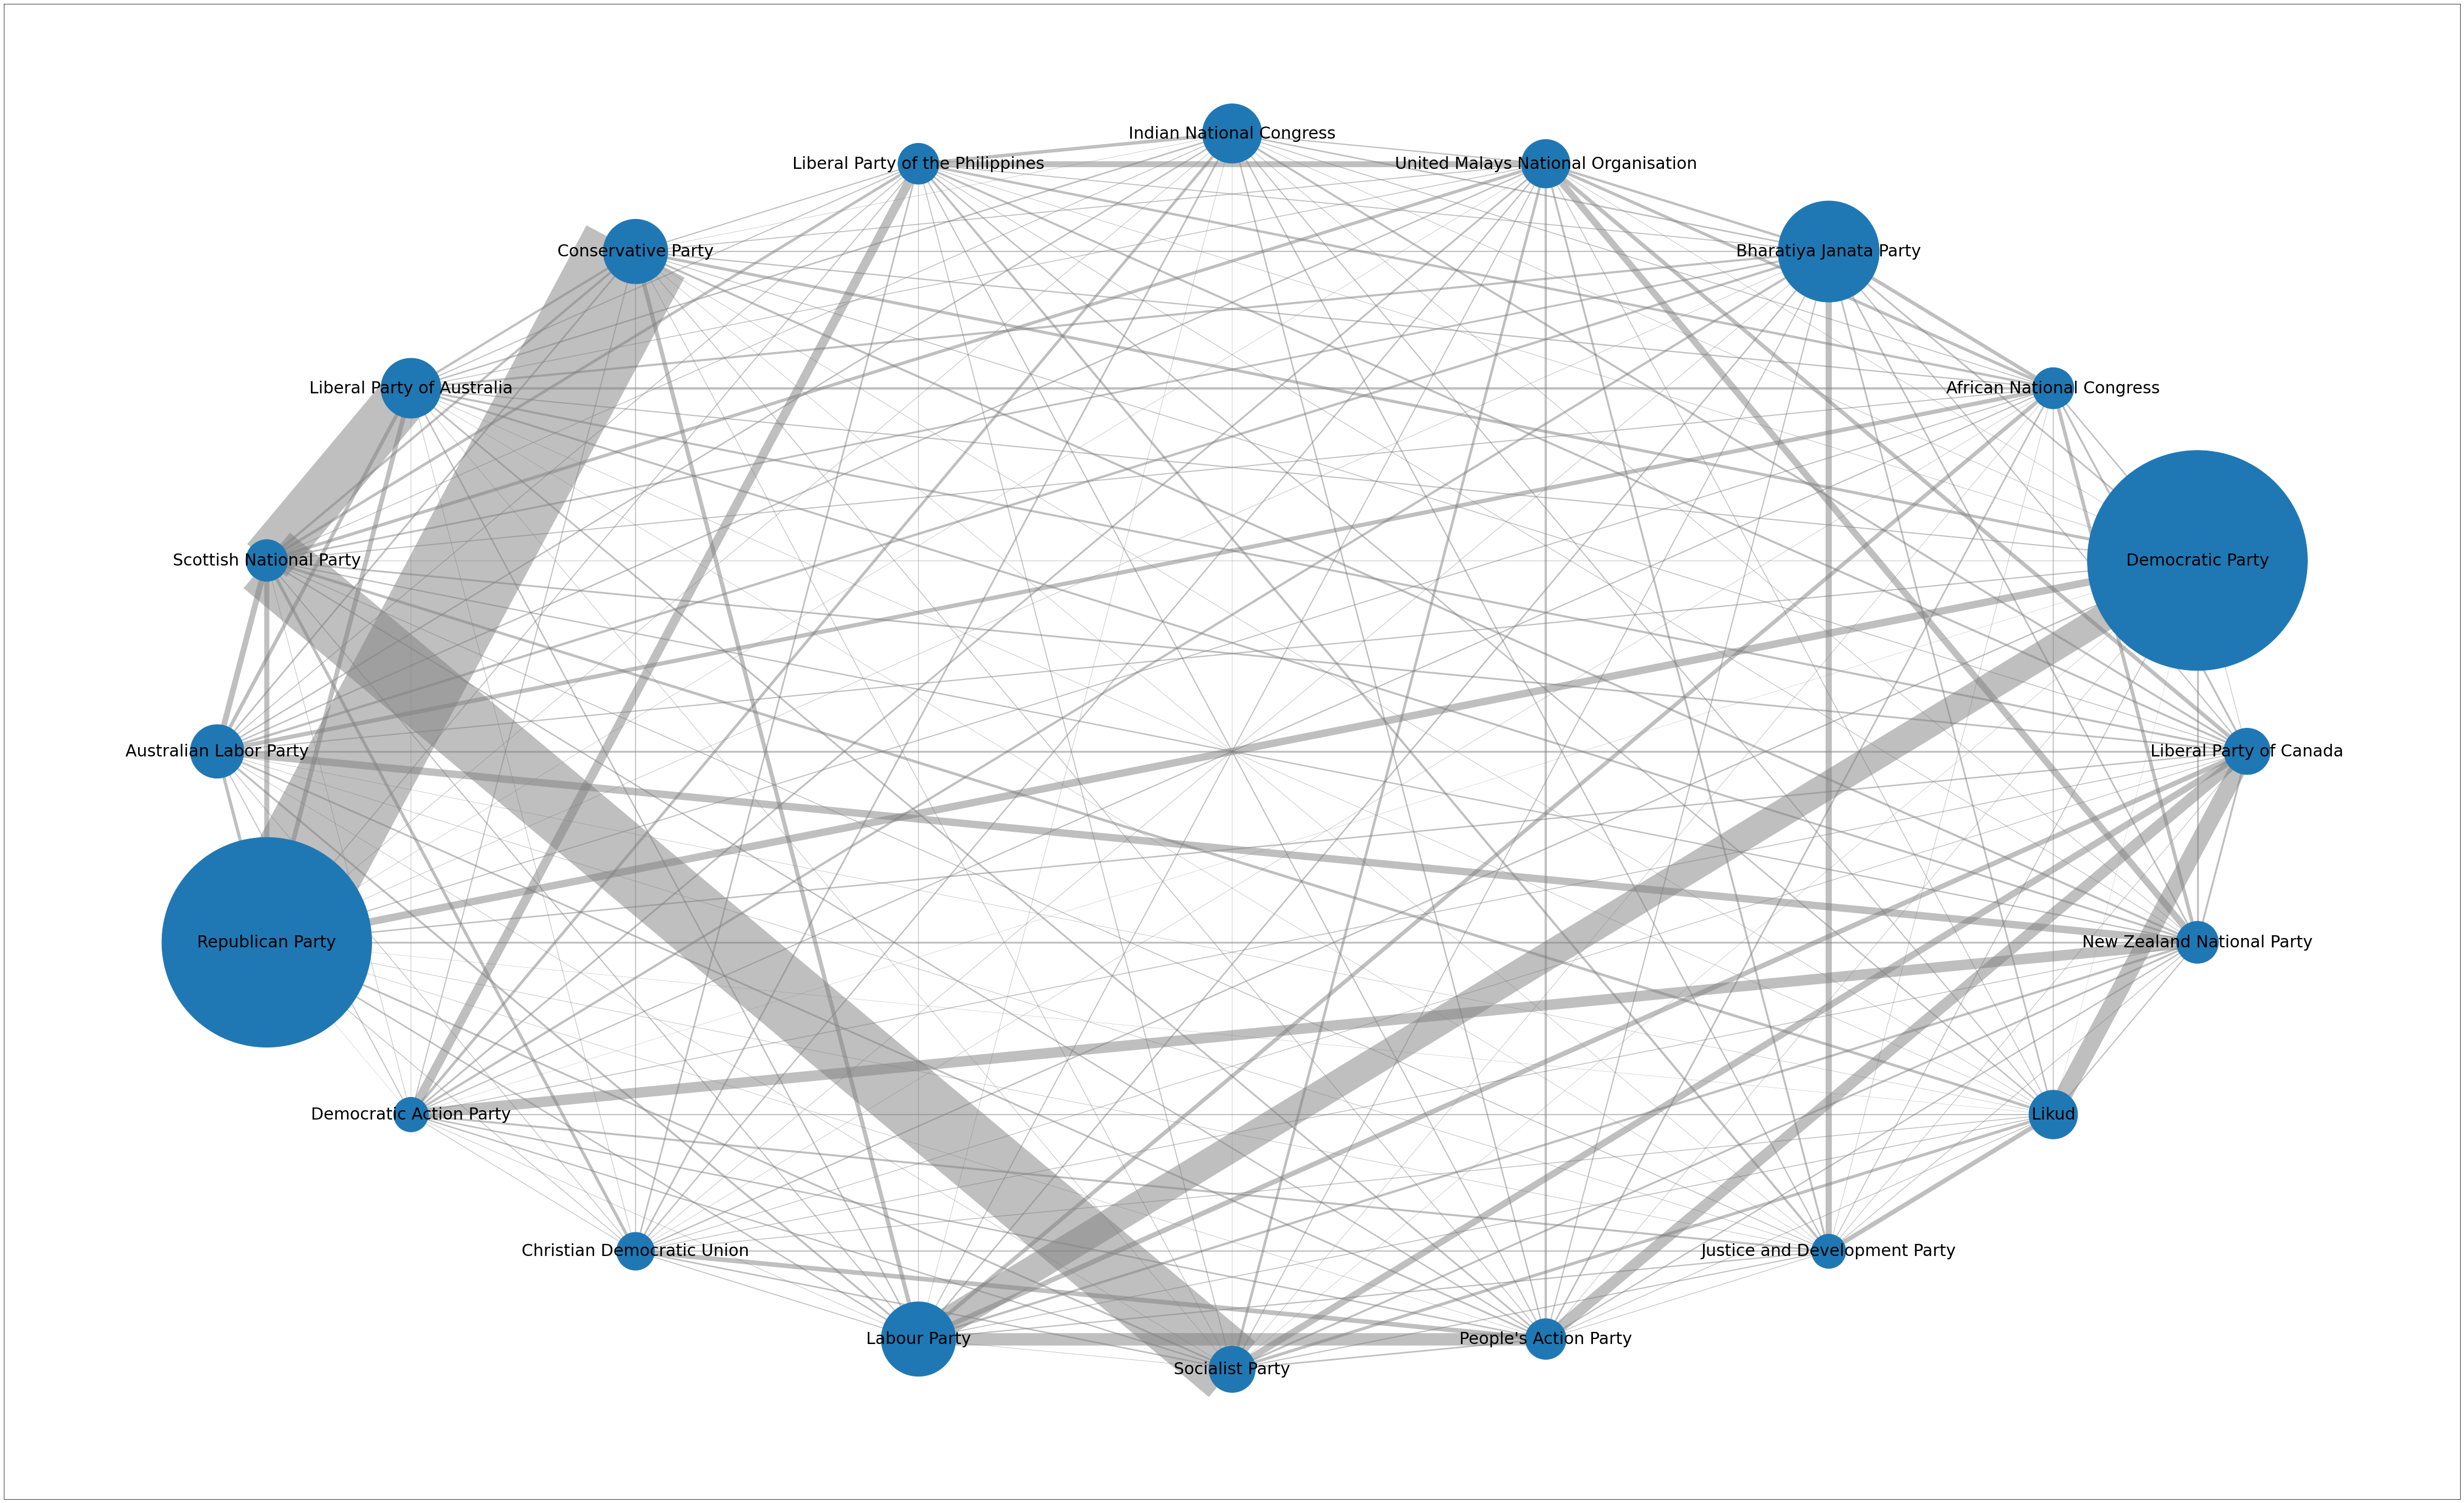

In [ ]:
def weight_edges_abs_diff_divide(G, u, v, weight='weight'):
    w = 0
    # print(u, v)
    for nbr in set(G[u]) & set(G[v]):
        w += 1 / (abs(G.edges[u, nbr].get(weight, 0) -  G.edges[v, nbr].get(weight, 0)))
    # print(w)
    return w

def weight_edges_abs_diff_jacard(G, u, v, weight='weight'):
    w = 0
    intersect = 0
    # print(u, v)
    for nbr in set(G[u]) & set(G[v]):
        if abs(G.edges[u, nbr].get(weight, 0) - G.edges[v, nbr].get(weight, 0)) <= 0.5:
            intersect += 1
    w = intersect / len(set(G[u]) & set(G[v])) * 100
    # print(w)
        
    return w

projected_G = nx.algorithms.bipartite.generic_weighted_projected_graph(G, nx.bipartite.sets(G)[0], weight_function=weight_edges_abs_diff_divide)

weights = []
for node1, node2, data in projected_G.edges(data=True):
    # data['weight'] /= 5
    # data['weight'] /= 200
    data['weight'] /= 50

    weights.append(data['weight'])

fig, ax = plt.subplots(figsize=(80,50))
# pos = nx.spring_layout(projected_G)
pos = nx.circular_layout(projected_G)

nx.draw_networkx_nodes(projected_G, pos, ax=ax, node_size=list(map(lambda x: nodes_size.loc[x].values[0], projected_G.nodes())))
nx.draw_networkx_edges(projected_G, pos, ax=ax, width=weights, edge_color='grey', alpha=0.5)
_ = nx.draw_networkx_labels(projected_G, pos, {i:i for i in dict(projected_G.nodes).keys()}, ax=ax, font_size=30)